In [2]:
#!pip install finance-datareader

import pandas as pd
import numpy as np
import pandas_datareader as web
import datetime
import FinanceDataReader as fdr
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM

Text(0, 0.5, 'price')

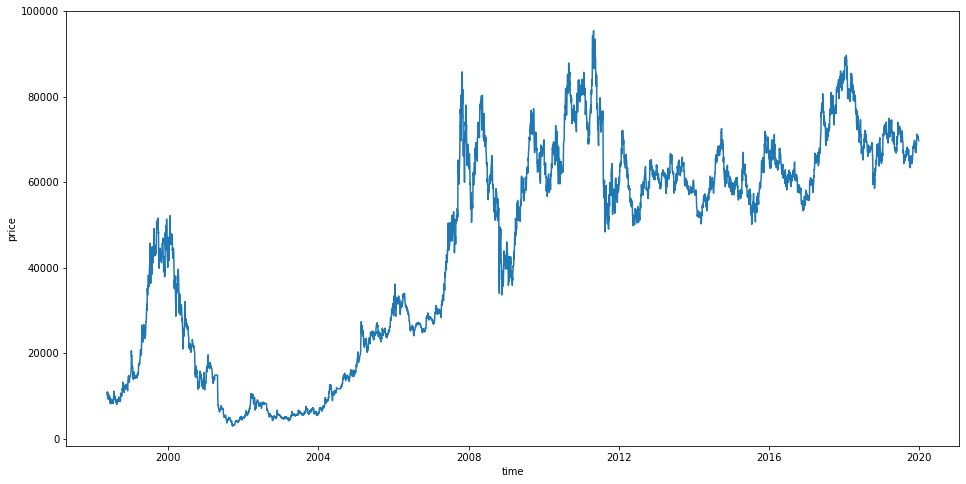

In [3]:
#df_krx = fdr.StockListing('KOSPI')

start = datetime.datetime(1990,1,1)
end = datetime.datetime(2020,1,1)

df = fdr.DataReader('003550',start, end)
df   # 데이터 확인해보자

plt.figure(figsize = (16,8))
plt.plot(df['Close'])   # Close 주식 장 마감시
data = df.filter(['Close']).values
plt.xlabel('time')
plt.ylabel('price')

In [40]:
scalar = MinMaxScaler(feature_range=(0,1))  # 최대값이 1이 되도록 전체 값을 최대값 나누어 주는 클래스 생성
scaled_data = scalar.fit_transform(data)  #데이터에 클래스 적용
scaled_data



training_data_len = math.ceil(len(scaled_data)*0.8)  #math ceil = 내림/반올림/올림 연산 중 올림 연산


train_data = scaled_data[0:training_data_len] 
train_data


x_train =[]
y_train = []

PAST_SET = 10

for i in range(PAST_SET, len(train_data)):
    x_train.append(train_data[i-PAST_SET:i,0])
    y_train.append(train_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape




model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(40, return_sequences=True))
model.add(LSTM(30, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam',loss = 'mean_squared_error')
model.fit(x_train,y_train, batch_size = 10, epochs =10)
# 한 턴에 1,000개씩 10번 , 5턴을 학습시킨다고 하면, batch_size = 1,000 / iteration = 10 /epoch = 5입니다.
'''
 [평균 제곱근 오차(Root Mean Square Error; RMSE)]
 추정 값 또는 모델이 예측한 값과 실제 환경에서 관찰되는 값의 차이를 다룰 때 흔히 사용하는 측도 .
'''
#batch size가 작아질수록 rsme값이 작아진다.


test_data = scaled_data[training_data_len - PAST_SET:,:]

x_test = []
y_test = scaled_data[training_data_len:,:]
for i in range(PAST_SET,len(test_data)):
    x_test.append(test_data[i-PAST_SET:i,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1) )

predictions = model.predict(x_test)
predictions = scalar.inverse_transform(predictions) #역행렬

Epoch 1/10
429/429 [==============================] - 17s 29ms/step - loss: 0.0042
Epoch 2/10
429/429 [==============================] - 12s 29ms/step - loss: 9.3521e-04
Epoch 3/10
429/429 [==============================] - 12s 28ms/step - loss: 9.0631e-04
Epoch 4/10
429/429 [==============================] - 12s 29ms/step - loss: 8.8562e-04
Epoch 5/10
429/429 [==============================] - 12s 28ms/step - loss: 8.6456e-04
Epoch 6/10
429/429 [==============================] - 13s 30ms/step - loss: 6.8199e-04
Epoch 7/10
429/429 [==============================] - 13s 31ms/step - loss: 5.4386e-04
Epoch 8/10
429/429 [==============================] - 13s 30ms/step - loss: 4.6747e-04
Epoch 9/10
429/429 [==============================] - 13s 30ms/step - loss: 3.6070e-04
Epoch 10/10
34/34 [==============================] - 1s 12ms/step


/tmp/ipykernel_7903/1470401133.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


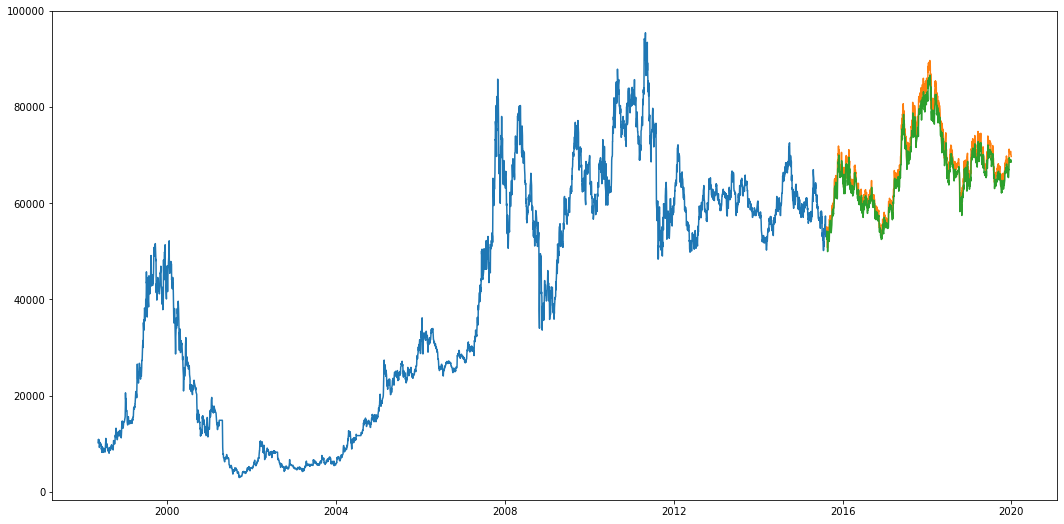

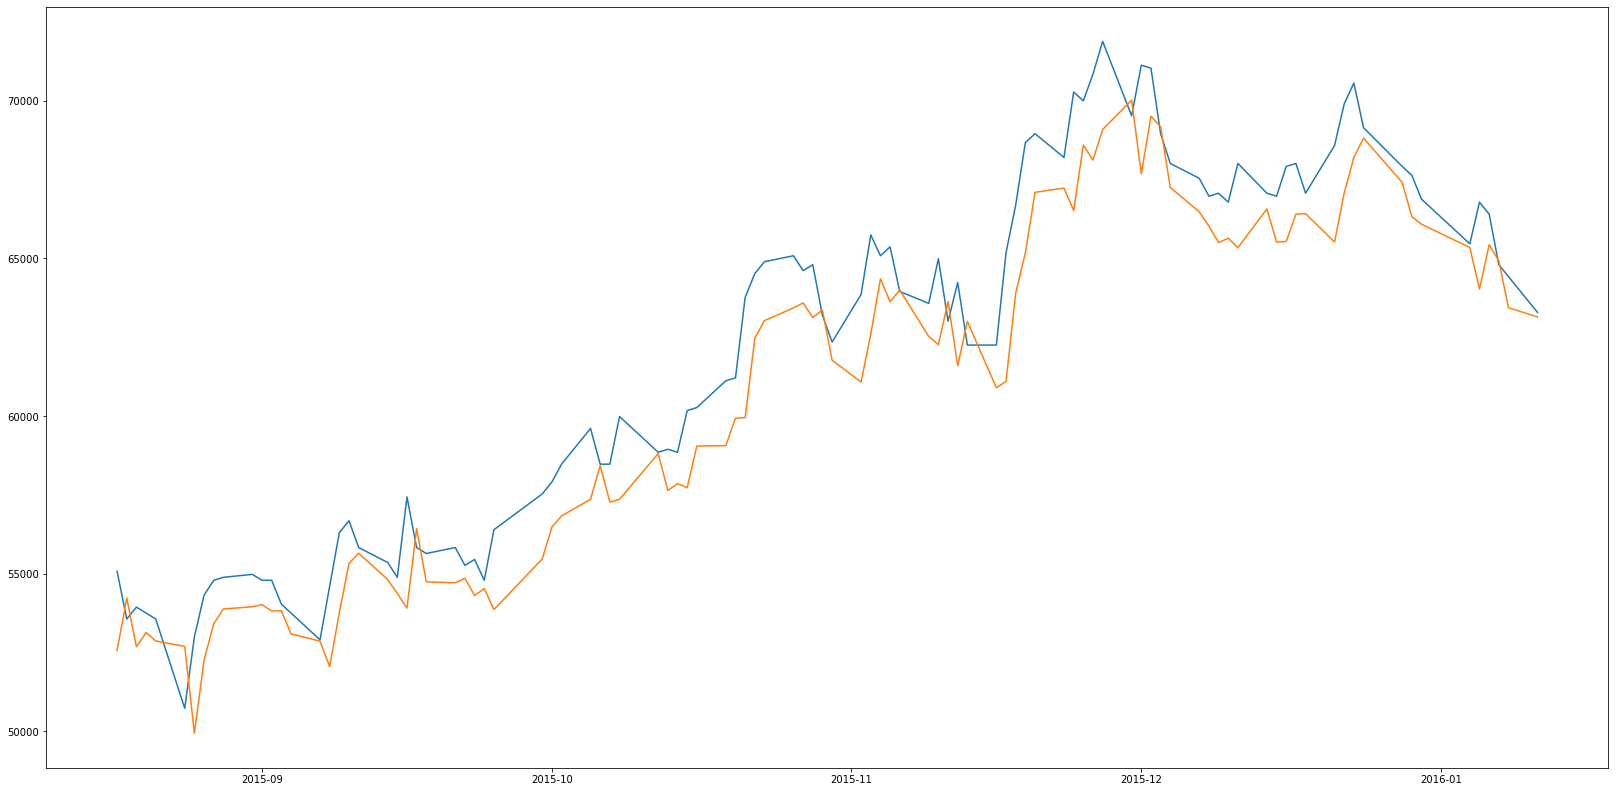

In [38]:
rmse = np.sqrt(np.mean((predictions - data[training_data_len:])**2)) #표준편차


data =df.filter(['Close'])

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(18,9))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
#plt.legend(['Train','Val','Predictions'],loc='low')


plt.figure(figsize=(28,14))
plt.plot(valid[['Close','Predictions']][:100])

In [39]:
rmse

Close    2009.489699
dtype: float64

plt.figure(figsize=(12, 9))
plt.plot(train, label='actual')

plt.plot(predictions, label='prediction')
plt.legend()
plt.show()

batch_size = 5, epoch = 5 => rmse : 1856.610599
batch_size = 5, epoch = 10 => rmse : 1156.818957
batch_size = 5, epoch = 15 => rmse : 2009.489699

batch_size = 10, epoch = 5 => rmse : 2737.160013
batch_size = 10, epoch = 10 => rmse : 1117.722431 -> 1269.520185